# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 6: Trees, Bagging, Random Forests, and Boosting


**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader and Chris Tanner

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs, and it is encouraged for you to do so. Especially during covid and distancing, this can be a way to work with other students and learn alongside one another. As future data scientists, you will often be expected to work with others, and working in pairs can help practice communicating data science concepts.

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit. Exceptions should be made for code with a long execution time, of course.
- We have tried to include all the libraries you may need to do the assignment in the imports statement at the top of this notebook. We strongly suggest that you use those and not others as we may not be familiar with them. .
- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**. 
- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that includes a reference to the calculated value, **not hardcoded**. For example: 
```
print(f'The R^2 is {R:.4f}')
```

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. 

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

In [3]:
# Load data
data_train = pd.read_csv('data/Higgs_train.csv')
data_test = pd.read_csv('data/Higgs_test.csv')

print(f"{len(data_train)} training samples, {len(data_test)} test samples")
print("\nColumns:")
print(', '.join(data_train.columns))

5000 training samples, 5000 test samples

Columns:
lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb, class


In [4]:
display(data_train.head())
display(data_train.describe())

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


In [5]:
# Split into NumPy arrays
X_train = data_train.iloc[:, data_train.columns != 'class'].values
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class'].values
y_test = data_test['class'].values

## Contents
- [Question 1 [20pts]: A Single Model](#Question-1-[20pts]:-A-Single-Model) 
- [Question 2 [25pts]: Bagging](#Question-2-[25pts]:-Bagging) 
- [Question 3 [20pts]: Random Forests](#Question-3-[20pts]:-Random-Forests) 
- [Question 4 [20pts]: Boosting](#Question-4-[20pts]:-Boosting) 
- [Question 5 [15pts]: Understanding](#Question-5-[15pts]:-Understanding) 

### <div class='exercise'>Question 1 [20pts]: A Single Model</div>
[▲ Return to contents](#Contents)
<div class='exercise'>
    
We start by fitting a basic model, which will serve as our baseline model -- a model that we can use as a starting point and can reasonably compare to other models. We will pick a decision tree as our baseline model, and we will later include bagging, random forests, and boosting. We want a fair comparison, so it is important to keep important aspects of the experiments consistent (e.g., the training/dev/testing data). We will tune the decision tree using cross-validation (of course). We will tune the maximum tree depth; we refer to this hyper-parameter as "depth" for simplicity.

Since we will only use tree-based methods in this homework, we do not need to standardize or normalize the predictors/independent variables. 

**1.1** In this problem, we will observe how both tree-depth and cross-validation affect our ability to accurately model data. Specifically, using tree depths from 1 to 20 (inclusive):
- fit a decision tree to the **training** set
- evaluate on the **training** set (i.e., `.score()`), while storing the scores in a variable named `train_scores`
- using cross-validation, evaluate on the **training** set while storing the mean and +/- 2 standard deviations in variables named `cvmeans` and `cvstds`, respectively.

Now that we have these informative scores, let us plot them. Specifically, for each tree-depth (x-axis) plot on the y-axis: (a) the initial, non-cross-validation training scores; and (b) a shaded region that illustrates cross-validations' estimated mean +/- 2 standard deviations. (c) set the limits on the y-axis to focus on the cross-validation performance.

*Hint:* use `plt.fill_between()` to shade the region.
    
**1.2** Using the cross-validation experiments from above, select a depth you deem most appropriate for using on future, unseen data, and justify your choice. Then, using this depth, report the classification accuracy on the **test** set. Store the training and testing accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score`, respectively, which we will refer to in later questions.

**1.3** What is the name of the mechanism by which limiting the tree's depth avoids over-fitting? What is one downside of limiting the tree depth? 
    
</div>

## Answers

<div class='exercise-r'>  
 
**1.1** In this problem, we will observe how both tree-depth and cross-validation affect our ability to accurately model data. Specifically, using tree depths from 1 to 20 (inclusive):
 - fit a decision tree to the **training** set
 - evaluate on the **training** set (i.e., `.score()`), while storing the scores in a variable named `train_scores`
 - using cross-validation, evaluate on the **training** set while storing the mean and +/- 2 standard deviations in variables named `cvmeans` and `cvstds`, respectively.
 
 Now that we have these informative scores, let us plot them. Specifically, for each tree-depth (x-axis) plot on the y-axis: (a) the initial, non-cross-validation training scores; and (b) a shaded region that illustrates cross-validations' estimated mean +/- 2 standard deviations. (c) set the limits on the y-axis to focus on the cross-validation performance.
 
 *Hint:* use `plt.fill_between()` to shade the region.
 
 </div>

In [6]:
depths = list(range(1, 21))

def calc_meanstd(X_train, y_train, depths):
    cvmeans, cvstds, train_scores = [], [], []    
    for depth in depths:
        tree = DecisionTreeClassifier(max_depth=depth)
        val_scores = cross_val_score(tree, X_train, y_train, cv=10)
        cvmeans.append(np.mean(val_scores))
        cvstds.append(np.std(val_scores))
        tree.fit(X_train, y_train)
        train_scores.append(tree.score(X_train, y_train))
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores= calc_meanstd(X_train, y_train, depths)

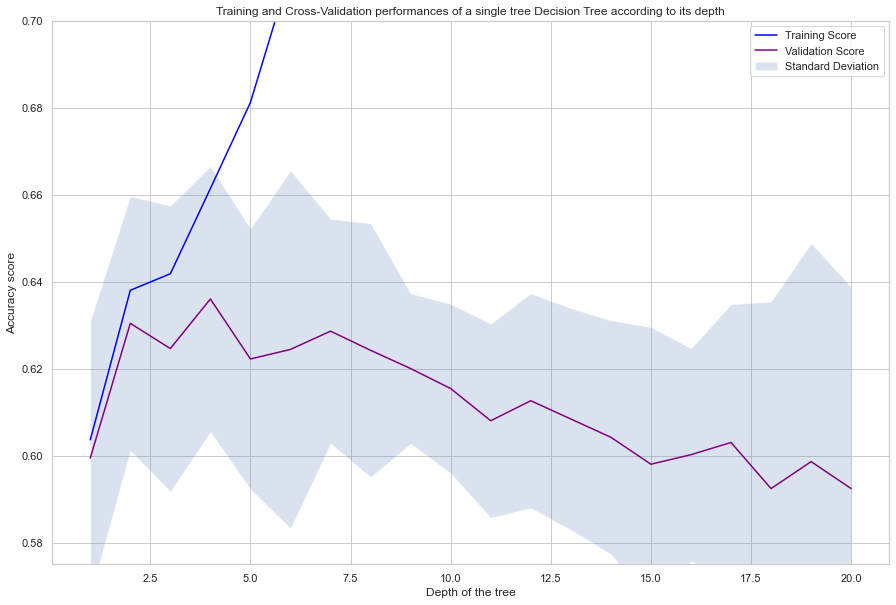

In [7]:
# your code here 
fig, ax = plt.subplots(1, figsize = (15, 10))
ax.plot(depths, train_scores, color='blue', label='Training Score')
ax.plot(depths, cvmeans, color='purple', label='Validation Score')
ax.fill_between(depths, np.asarray(cvmeans)-2*np.asarray(cvstds), np.asarray(cvmeans)+2*np.asarray(cvstds), alpha= 0.2, label='Standard Deviation')
ax.legend()
ax.set_ylim(0.575, 0.7)
ax.set_xlabel('Depth of the tree')
ax.set_ylabel('Accuracy score')
ax.set_title('Training and Cross-Validation performances of a single tree Decision Tree according to its depth')
plt.show(fig)

<div class='exercise-r'>  
 
**1.2** Using the cross-validation experiments from above, select a depth you deem most appropriate for using on future, unseen data, and justify your choice. Then, using this depth, report the classification accuracy on the **test** set. Store the training and testing accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score`, respectively, which we will refer to in later questions.
 
 </div>

In [8]:
# your code here
best_depth = depths[np.argmax(cvmeans)]
print('According to our experiment, the best depth is ', best_depth)

According to our experiment, the best depth is  4


We chose the best_depth according to cross validation performances because it allows us to select the model that would perform best on **unseen** data. 

In [9]:
tree = DecisionTreeClassifier(max_depth=best_depth).fit(X_train, y_train)
best_cv_tree_train_score , best_cv_tree_test_score = tree.score(X_train, y_train), tree.score(X_test, y_test)

In [10]:
best_cv_tree_train_score , best_cv_tree_test_score

(0.6614, 0.651)

*Your answer here*

<div class='exercise-r'>  
 
**1.3** What is the name of the mechanism by which limiting the tree's depth avoids over-fitting? What is one downside of limiting the tree depth?
 
 </div>

*Your answer here*

### <div class='exercise'>Question 2 [25pts]: Bagging</div>
[▲ Return to contents](#Contents)

<div class='exercise'>
Bagging is the technique of building the same model on multiple bootstrap samples from the data and combining each model's prediction to get an overall classification. In this question, we build an example by hand and study how the number of bootstrapped datasets impacts the resulting classification accuracy.



**2.1** Using decision trees and the previous question's data, choose a tree depth that WILL overfit the training set. What evidence leads you to believe that this depth overfits? Assign your choice to a variable named `tree_depth`. (You may want to explore different settings for this value in the problems below.)

**2.2** Create 55 bootstrapped replications of the original training data and fit a decision tree to each (using the tree depth you just chose in 2.1). Record each of the 55 trees' predictions. In particular, produce a dataset like those shown below, where each row is either a training and testing observation (depending on the partition of data at hand), and each column is one of the 55 trees. Each entry within a (row, col) is the corresponding tree's prediction for that observation.

Store these results as `bagging_train_df` and `bagging_test_df`. Don't worry about visualizing these results yet.

**2.3**  _Aggregate_ all 55 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the models predict that example to be from class 1. Assign the bagging test accuracy to a variable named `bagging_accuracy_test`. What accuracy does this *bagging* model achieve on the test set? Write an assertion that verifies that this test set accuracy is at least as good as the accuracy for the model you fit in Question 1.

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions()` function (given below) to get the model's accuracy score when using only $N$ of the bootstrapped models, where $N \in [1, 2, 3, ..., 55]$. Make a plot that illustrates the accuracy on the training set and testing set, as a function of the number of bootstraps (vary $N$ from 1 to 55). 
**Use the depth from 2.1** 

On your plot, also include horizontal lines for two baselines:
- the test accuracy of the best model from question 1
- the test accuracy of a single tree with the tree depth you chose in 2.1, trained on the full training set.

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain the differences you see.

**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 2.5.

**2.7**: In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?

**Hints**
- Use `resample()` from `sklearn` to easily bootstrap the $x$ and $y$ data.
- use `np.mean()` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?
    
</div>

## Answers

<div class='exercise-r'>  
 
**2.1** Using decision trees and the previous question's data, choose a tree depth that WILL overfit the training set. What evidence leads you to believe that this depth overfits? Assign your choice to a variable named `tree_depth`. (You may want to explore different settings for this value in the problems below.)
 
 </div>

In [11]:
# Assign your choice to a variable named tree_depth
# your code here
tree_depth = 15

According to our previous experiment, we have seen that there is a dramatic drop in performances between the training and validation performances for trees grown with a maximal depth = 15. This is a strong indicator of overfitting.

<div class='exercise-r'>  
 
**2.2** Create 55 bootstrapped replications of the original training data and fit a decision tree to each (using the tree depth you just chose in 2.1). Record each of the 55 trees' predictions. In particular, produce a dataset like those shown below, where each row is either a training and testing observation (depending on the partition of data at hand), and each column is one of the 55 trees. Each entry within a (row, col) is the corresponding tree's prediction for that observation.
 
 Store these results as `bagging_train_df` and `bagging_test_df`. Don't worry about visualizing these results yet.
 
 </div>

**Structure of `bagging_train_df` and `bagging_test_df`:**

`bagging_train`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 55's prediction|  
| --- | --- | --- | --- | --- |
|training row 1| binary value | binary value|... |binary value|
|training row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

`bagging_test`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 55's prediction|
| --- | --- | --- | --- | --- |
|test row 1| binary value | binary value|... |binary value|
|test row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |


In [12]:
import itertools

In [13]:
def bagger(n_trees: int, tree_depth: int,  random_seed=0) -> (pd.DataFrame, pd.DataFrame, list):
    """A function that takes as 
    
    Inputs:
      n_tres
      tree_depth 
      a random_seed (default =0)
    
    Returns:
      bagging_train dataframe (as described above)
      bagging_test dataframe (as described above)
      bagging_models every trained model for each bootstrap (you will need this in Q3.2)
    """
    predictions_train = []
    predictions_test = []
    models = []
    for _ in itertools.repeat(None, n_trees):
        resample_indexes = np.random.choice(np.arange(y_train.shape[0]), size=y_train.shape[0])
        X_boot = X_train[resample_indexes]
        y_boot = y_train[resample_indexes]
        tree = DecisionTreeClassifier(max_depth=tree_depth).fit(X_boot, y_boot)
        predictions_train.append(tree.predict(X_train))
        predictions_test.append(tree.predict(X_test))
        models.append(tree)
    return pd.DataFrame(np.asarray(predictions_train).T), pd.DataFrame(np.asarray(predictions_test).T), models 

In [14]:
# your code here
bagging_train, bagging_test, models = bagger(55, tree_depth, 0)

In [15]:
bagging_train.shape

(5000, 55)

<div class='exercise-r'>  
 
**2.3**  _Aggregate_ all 55 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the models predict that example to be from class 1. Assign the bagging test accuracy to a variable named `bagging_accuracy_test`. What accuracy does this *bagging* model achieve on the test set? Write an assertion that verifies that this test set accuracy is at least as good as the accuracy for the model you fit in Question 1.
 
 </div>

In [16]:
# your code here
combine_bagging_train = np.asarray([np.sum(prediction_train) > int(55/2) for prediction_train in bagging_train.values])
combine_bagging_test = np.asarray([np.sum(prediction_test) > int(55/2) for prediction_test in bagging_test.values])
bagging_accuracy_train = accuracy_score(combine_bagging_train, y_train)
bagging_accuracy_test = accuracy_score(combine_bagging_test, y_test)
assert(bagging_accuracy_test >= best_cv_tree_test_score)
print('The bootstrap aggregation score on the test set is ', bagging_accuracy_test)

The bootstrap aggregation score on the test set is  0.6848


<div class='exercise-r'>  
 
**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions()` function (given below) to get the model's accuracy score when using only $N$ of the bootstrapped models, where $N \in [1, 2, 3, ..., 55]$. Make a plot that illustrates the accuracy on the training set and testing set, as a function of the number of bootstraps (vary $N$ from 1 to 55).
 **Use the depth from 2.1**
 
 On your plot, also include horizontal lines for two baselines:
 - the test accuracy of the best model from question 1
 - the test accuracy of a single tree with the tree depth you chose in 2.1, trained on the full training set.
 
 </div>

In [17]:
def running_predictions(prediction_dataset: np.ndarray, targets: np.ndarray) -> np.ndarray:
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset (not a dataframe), where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    return np.mean(running_correctnesss, axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

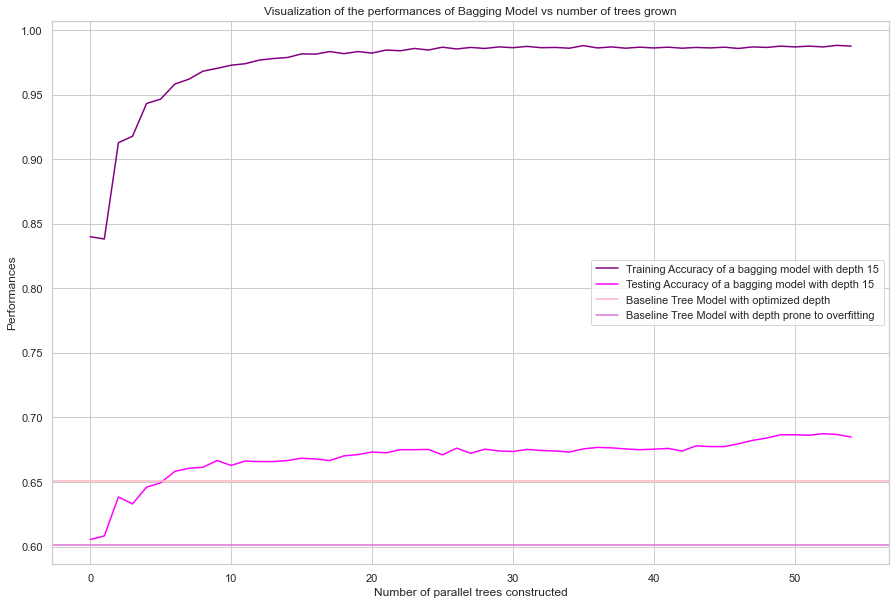

In [18]:
# plotting code
# your code here
tree = DecisionTreeClassifier(max_depth=15).fit(X_train, y_train)
score_overfitting_train, score_overfitting_test = tree.score(X_train, y_train), tree.score(X_test, y_test)
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.plot(range(55), running_predictions(bagging_train, y_train), color='purple', label='Training Accuracy of a bagging model with depth 15')
ax.plot(range(55), running_predictions(bagging_test, y_test), color='magenta', label='Testing Accuracy of a bagging model with depth 15')
ax.axhline(best_cv_tree_test_score, color='lightpink', label='Baseline Tree Model with optimized depth')
ax.axhline(score_overfitting_test, color='orchid', label='Baseline Tree Model with depth prone to overfitting')
ax.legend()
ax.set_xlabel('Number of parallel trees constructed')
ax.set_ylabel('Performances')
ax.set_title('Visualization of the performances of Bagging Model vs number of trees grown')
plt.show(fig)

<div class='exercise-r'>  
 
**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain the differences you see.
 
 </div>

We can see that the performances of bagging are significantly better than when using a single tree with depth 15. This is due to the fact that bagging solves the overfitting issue we have encountered when growing a tree with such depth. The way bagging deals with overfitting is that it lowers the variance of the resulting model by averaging th epredictions over several *not really independent* models.

<div class='exercise-r'>  
 
**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 2.5.
 
 </div>

*Your answer here*

<div class='exercise-r'>  
 
**2.7**: In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?
 
 **Hints**
 - Use `resample()` from `sklearn` to easily bootstrap the $x$ and $y$ data.
 - use `np.mean()` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?
 
 </div>

From what I understood, we try to reduce the overfitting of our model by creating several parallel models. Aggregating the response into a mean predictive model will allow us to reduce the variance in the resulting model, thus preventing high variance in the model and therefore preventing overfitting. However, when the number of parallel trees start increasing, the datasets on which we train different trees might become similar across the ensemble model, which creates some correlation between our predictors and therefore does not allow us to efficiently reduce the variance in the prediction. This is how a bagging model might be overfitting the data. It might be underfitting the data when specifying a low number of trees constructed with some unadapted depth for our trees (too low to capture complew decision boundaries).

### <div class='exercise'>Question 3 [20pts]: Random Forests</div>
[▲ Return to contents](#Contents)

<div class='exercise'>
Random Forests are closely related to the bagging model we built by hand in question 2. In this question, we compare our by-hand results with the results of using `RandomForestClassifier` directly.


**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees you used in Question 2.2. Set the number of features to use when looking for the best split to be  `sqrt(total_number of features)`. Evaluate its accuracy on the test set and assign it to a variable name `random_forest_test_score`.

**3.2** Among all of the decision trees you fit in the bagging process, how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? Assign the answers to these questions to two pandas Series called `top_predictors_bagging` and `top_predictors_rf`, and display them on the screen.

Explain:
* What about the process of training the Random Forest causes this difference?
* What implication does this observation have on the accuracy of bagging vs Random Forest?

**Hint**: A decision tree's top feature is stored in `model.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.

**3.3**: Make a Pandas table of the training and test accuracy for the following models and name it `results_df`:

- Single tree with the best depth chosen by cross-validation (from Question 1)
- A single overfit tree trained on all data (from Question 2, using the depth you chose there)
- Bagging 55 such trees (from Question 2)
- A Random Forest of 55 such trees (from Question 3.1)

(see below for the expected structure)  

(This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.

</div>

## Answers

<div class='exercise-r'>  
 
**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees you used in Question 2.2. Set the number of features to use when looking for the best split to be  `sqrt(total_number of features)`. Evaluate its accuracy on the test set and assign it to a variable name `random_forest_test_score`.
 
 </div>

In [19]:
# your code here
rf = RandomForestClassifier(n_estimators=55, max_depth=tree_depth, max_features='sqrt').fit(X_train, y_train)
random_forest_test_score=rf.score(X_test, y_test)
random_forest_train_score = rf.score(X_train, y_train)
random_forest_test_score

0.6918

<div class='exercise-r'>  
 
**3.2** Among all of the decision trees you fit in the bagging process, how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? Assign the answers to these questions to two pandas Series called `top_predictors_bagging` and `top_predictors_rf`, and display them on the screen.
 
 Explain:
 * What about the process of training the Random Forest causes this difference?
 * What implication does this observation have on the accuracy of bagging vs Random Forest?
 
 **Hint**: A decision tree's top feature is stored in `model.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.
 
 </div>

In [20]:
# your code here
dict_features = {}
top_predictors_bagging_list = []
top_predictors_rf_list = []
for model in models:
    tree = model.tree_
    top_feature = tree.feature[0]
    top_predictors_bagging_list.append(top_feature)
for estimator in rf.estimators_:
    tree = estimator.tree_
    top_feature = tree.feature[0]
    top_predictors_rf_list.append(top_feature)
top_predictors_bagging = pd.Series(top_predictors_bagging_list).value_counts()
top_predictors_rf = pd.Series(top_predictors_rf_list).value_counts()

In [21]:
display(top_predictors_bagging)

25    55
dtype: int64

In [22]:
display(top_predictors_rf)

27    10
3     10
0      8
25     7
22     7
24     3
5      3
26     2
19     1
14     1
10     1
9      1
6      1
dtype: int64

What causes this difference in the *first split* is that random forests sometimes are not exposed to the feature 25 when making a split. Indeed, at every split, we choose the best feature according to a random subset of features, which may not contain the feature 25.

The result aboug Bagging shows that the first split of the tree is **always** according to the feature 25, leading to very correlated trees. The random forests might grow trees that are less correlated, therefore reducing the variance in the predictions and enhancing the performances of our model, giving better generalization and better test accuracy.

<div class='exercise-r'>  
 
**3.3**: Make a Pandas table of the training and test accuracy for the following models and name it `results_df`:
 
 - Single tree with the best depth chosen by cross-validation (from Question 1)
 - A single overfit tree trained on all data (from Question 2, using the depth you chose there)
 - Bagging 55 such trees (from Question 2)
 - A Random Forest of 55 such trees (from Question 3.1)
 
 (see below for the expected structure)
 
 (This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)
 
 What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.
 
 </div>

Fill in the following table.


| classifier | training accuracy | test accuracy |
| --- | --- | --- |
| single tree with best depth chosen by CV | | |
| single depth-X tree | | |
| bagging 55 depth-X trees | | |
| Random Forest of 55 depth-X trees | | |

In [23]:
# your code here
results_df= pd.DataFrame({'classifier':['single tree with best depth chosen by CV', 'single depth-15 tree', 'Bagging 55 depth-15 trees', 'Random Forest of 55 depth-15 trees	'], 
                         'training accuracy':[best_cv_tree_train_score, score_overfitting_train, bagging_accuracy_train, random_forest_train_score], 
                         'testing accuracy':[best_cv_tree_test_score, score_overfitting_test, bagging_accuracy_test, random_forest_test_score]}, index=None)
display(results_df)

,classifier,training accuracy,testing accuracy
0,single tree with best depth chosen by CV,0.6614,0.6510
1,single depth-15 tree,0.9816,0.6014
2,Bagging 55 depth-15 trees,0.9876,0.6848
3,Random Forest of 55 depth-15 trees\t,0.9976,0.6918


Except the Decision Tree classifier, every model perform **very well** on the training set. The ensemble models are significantly better than the single classifiers on the testing set. This is explained by the fact that random forest is more robust to overfitting (by de-correlating the different trees) than bagging, which is itself more robust than a single Classification Tree by aggregating the results from different models. Last, we can see that the singme tree with depth 15 is overfitting our training set by learning unimportant features, more related to the noise in our training data.

### <div class='exercise'>Question 4 [20pts]: Boosting</div>
[▲ Return to contents](#Contents)

<div class='exercise'>
In this question, we explore a different kind of ensemble method, boosting. Each new model is trained on a dataset weighted towards observations that the current model predicts incorrectly. 

We will focus on the AdaBoost flavor of boosting and examine the ensemble model's accuracy as the algorithm adds more estimators (iterations) to the ensemble.

**4.1** We will motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data. 
Report the train and test accuracies. For each predictor, make a plot that compares two distributions: the values of that predictor for observations that `tree1` classifies correctly, and the values of that predictor for observations that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?
    
*Hints*:
- If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
- [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.

**4.2** The following code (see below) attempts to implement a simplified version of boosting using just two classifiers (described below). However, it has both stylistic and functionality flaws:
1. Imagine that you are a grader for a Data Science class; write a comment for the student who submitted this code.
2. Imagine that you're the TF writing the solutions; make an excellent example implementation.
3. Use your corrected code to compare the performance of `tree1` and the boosted algorithm on both the training and test set.

**4.3** Now, let us use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.

**4.4** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?

(It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)

**4.5** Based on the plot you just made, what combination of base learner depth and the number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?
</div>

## Answers

<div class='exercise-r'>  
 
**4.1** We will motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data.
 Report the train and test accuracies. For each predictor, make a plot that compares two distributions: the values of that predictor for observations that `tree1` classifies correctly, and the values of that predictor for observations that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?
 
 *Hints*:
 - If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
 - [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.
 
 </div>

In [24]:
# your code here
tree1 = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
training_accuracy_tree1 = tree1.score(X_train, y_train)
testing_accuracy_tree1 = tree1.score(X_test, y_test)
print('The training accuracy of our tree with depth 3 is ',training_accuracy_tree1)
print('The testing accuracy of our tree with depth 3 is ',testing_accuracy_tree1)

The training accuracy of our tree with depth 3 is  0.6418
The testing accuracy of our tree with depth 3 is  0.6442


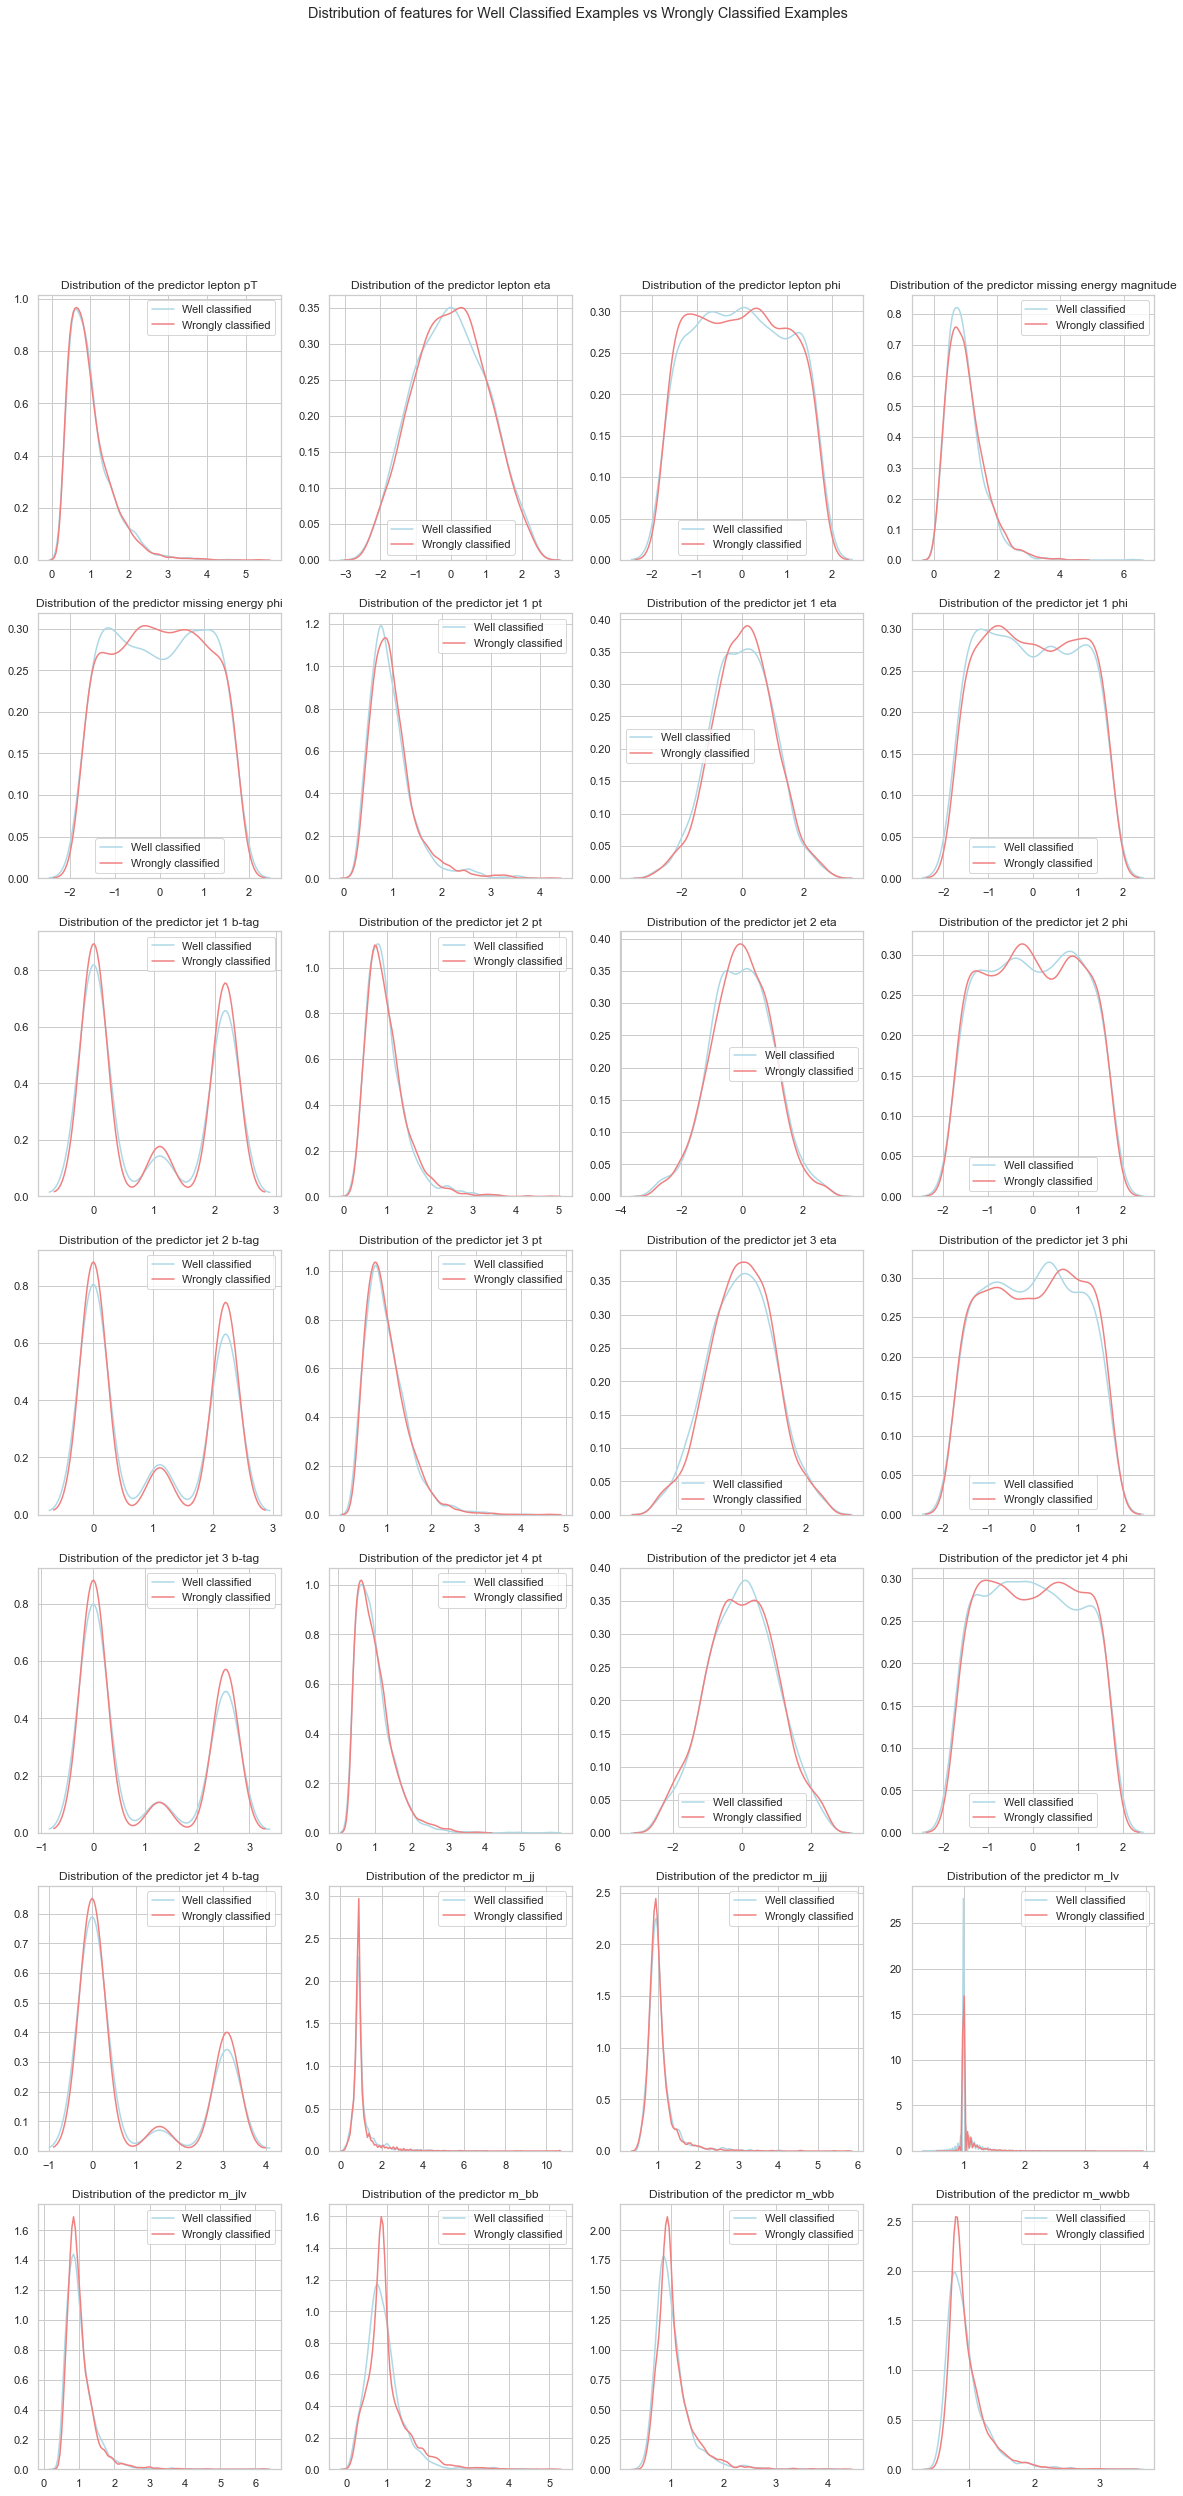

In [25]:
# your code here
training_predictions = tree1. predict(X_train)
examples_well_classified = X_train[training_predictions == y_train]
examples_wrongly_classified = X_train[training_predictions != y_train]
predictors = [predictor for predictor in data_train if predictor != 'class']
fig, axs = plt.subplots(7, 4, figsize = (20, 40))
plt.suptitle('Distribution of features for Well Classified Examples vs Wrongly Classified Examples')
for i, ax in enumerate(axs.ravel()):
    feature_well_classified = examples_well_classified[:, i]
    features_wrongly_classified = examples_wrongly_classified[:, i]
    sns.kdeplot(features_wrongly_classified, ax=ax, label='Well classified', color='lightblue')
    sns.kdeplot(feature_well_classified, ax=ax, label='Wrongly classified', color='lightcoral')
    ax.legend(loc='best')
    ax.set_title('Distribution of the predictor ' + str(predictors[i]))
    

I can't notice any predictors for which the distributions are clearly different.

<div class='exercise-r'>  
 
**4.2** The following code (see below) attempts to implement a simplified version of boosting using just two classifiers (described below). However, it has both stylistic and functionality flaws:
 1. Imagine that you are a grader for a Data Science class; write a comment for the student who submitted this code.
 2. Imagine that you're the TF writing the solutions; make an excellent example implementation.
 3. Use your corrected code to compare the performance of `tree1` and the boosted algorithm on both the training and test set.
 
 </div>

The intended functionality is the following:
1. Fit `tree1`, a decision tree with max depth 3.
2. Construct an array of sample weights. Give a weight of 1 to samples that `tree1` classified correctly, and 2 to samples that `tree1` misclassified.
3. Fit `tree2`, another depth-3 decision tree, using those sample weights.
4. To predict, compute the probabilities that `tree1` and `tree2` each assign to the positive class. Take the average of those two probabilities as the prediction probability.

In [26]:
def boostmeup(X, y):
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X, y)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
          if tree1.predict([X_train[idx]]) != y_train[idx]:
             sample_weight[idx] = sample_weight[idx] * 2
             q = q + 1
    print("tree1 accuracy:", q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup(X_train, y_train)

tree1 accuracy: 0.3582
Boosted accuracy: 0.0008
Boosted accuracy: 0.002


*Your answer here*

In [27]:
# your code here


<div class='exercise-r'>  
 
**4.3** Now, let us use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.
 
 *Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.
 
 </div>

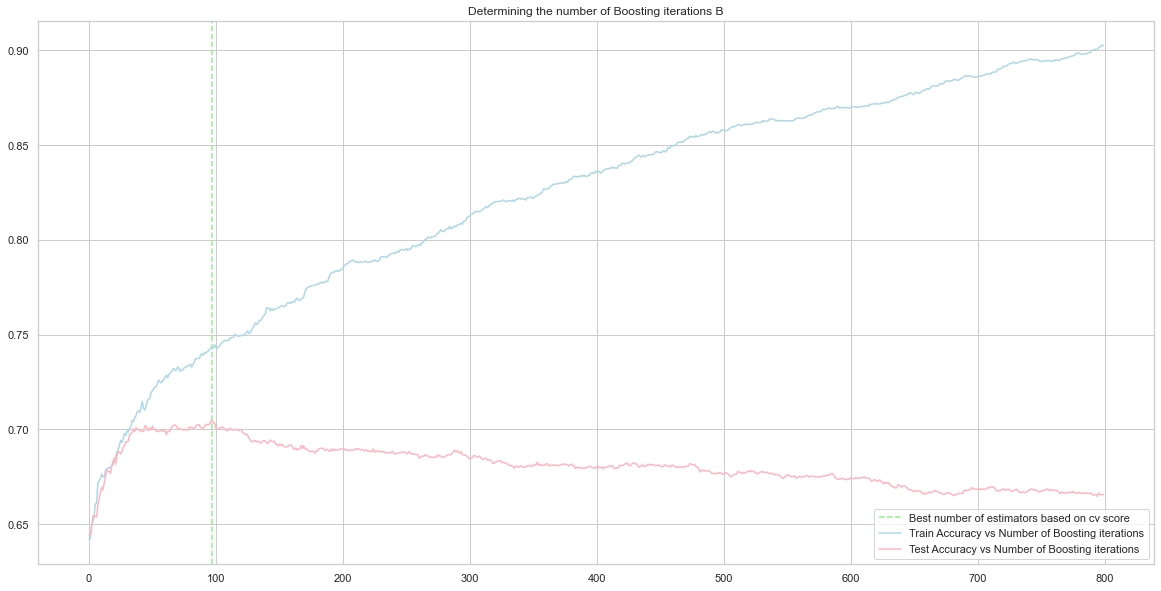

In [28]:
# your code here
boosting = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=800, learning_rate=0.05).fit(X_train, y_train)
staged_score_training = list(boosting.staged_score(X_train, y_train))
staged_score_testing = list(boosting.staged_score(X_test, y_test))
best_number_estimators = np.argmax(staged_score_testing)
fig, ax = plt.subplots(1, figsize =(20, 10))
ax.set_title('Determining the number of Boosting iterations B')
ax.axvline(best_number_estimators, linestyle='--', color='lightgreen', label='Best number of estimators based on cv score')
ax.plot(staged_score_training, color='lightblue', label='Train Accuracy vs Number of Boosting iterations')
ax.plot(staged_score_testing, color='lightpink', label='Test Accuracy vs Number of Boosting iterations')
ax.legend()
plt.show(fig)

In [29]:
best_boosting_depth_3_train = staged_score_training[best_number_estimators]
best_boosting_depth_3_test = staged_score_testing[best_number_estimators]

<div class='exercise-r'>  
 
**4.4** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?
 
 (It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)
 
 </div>

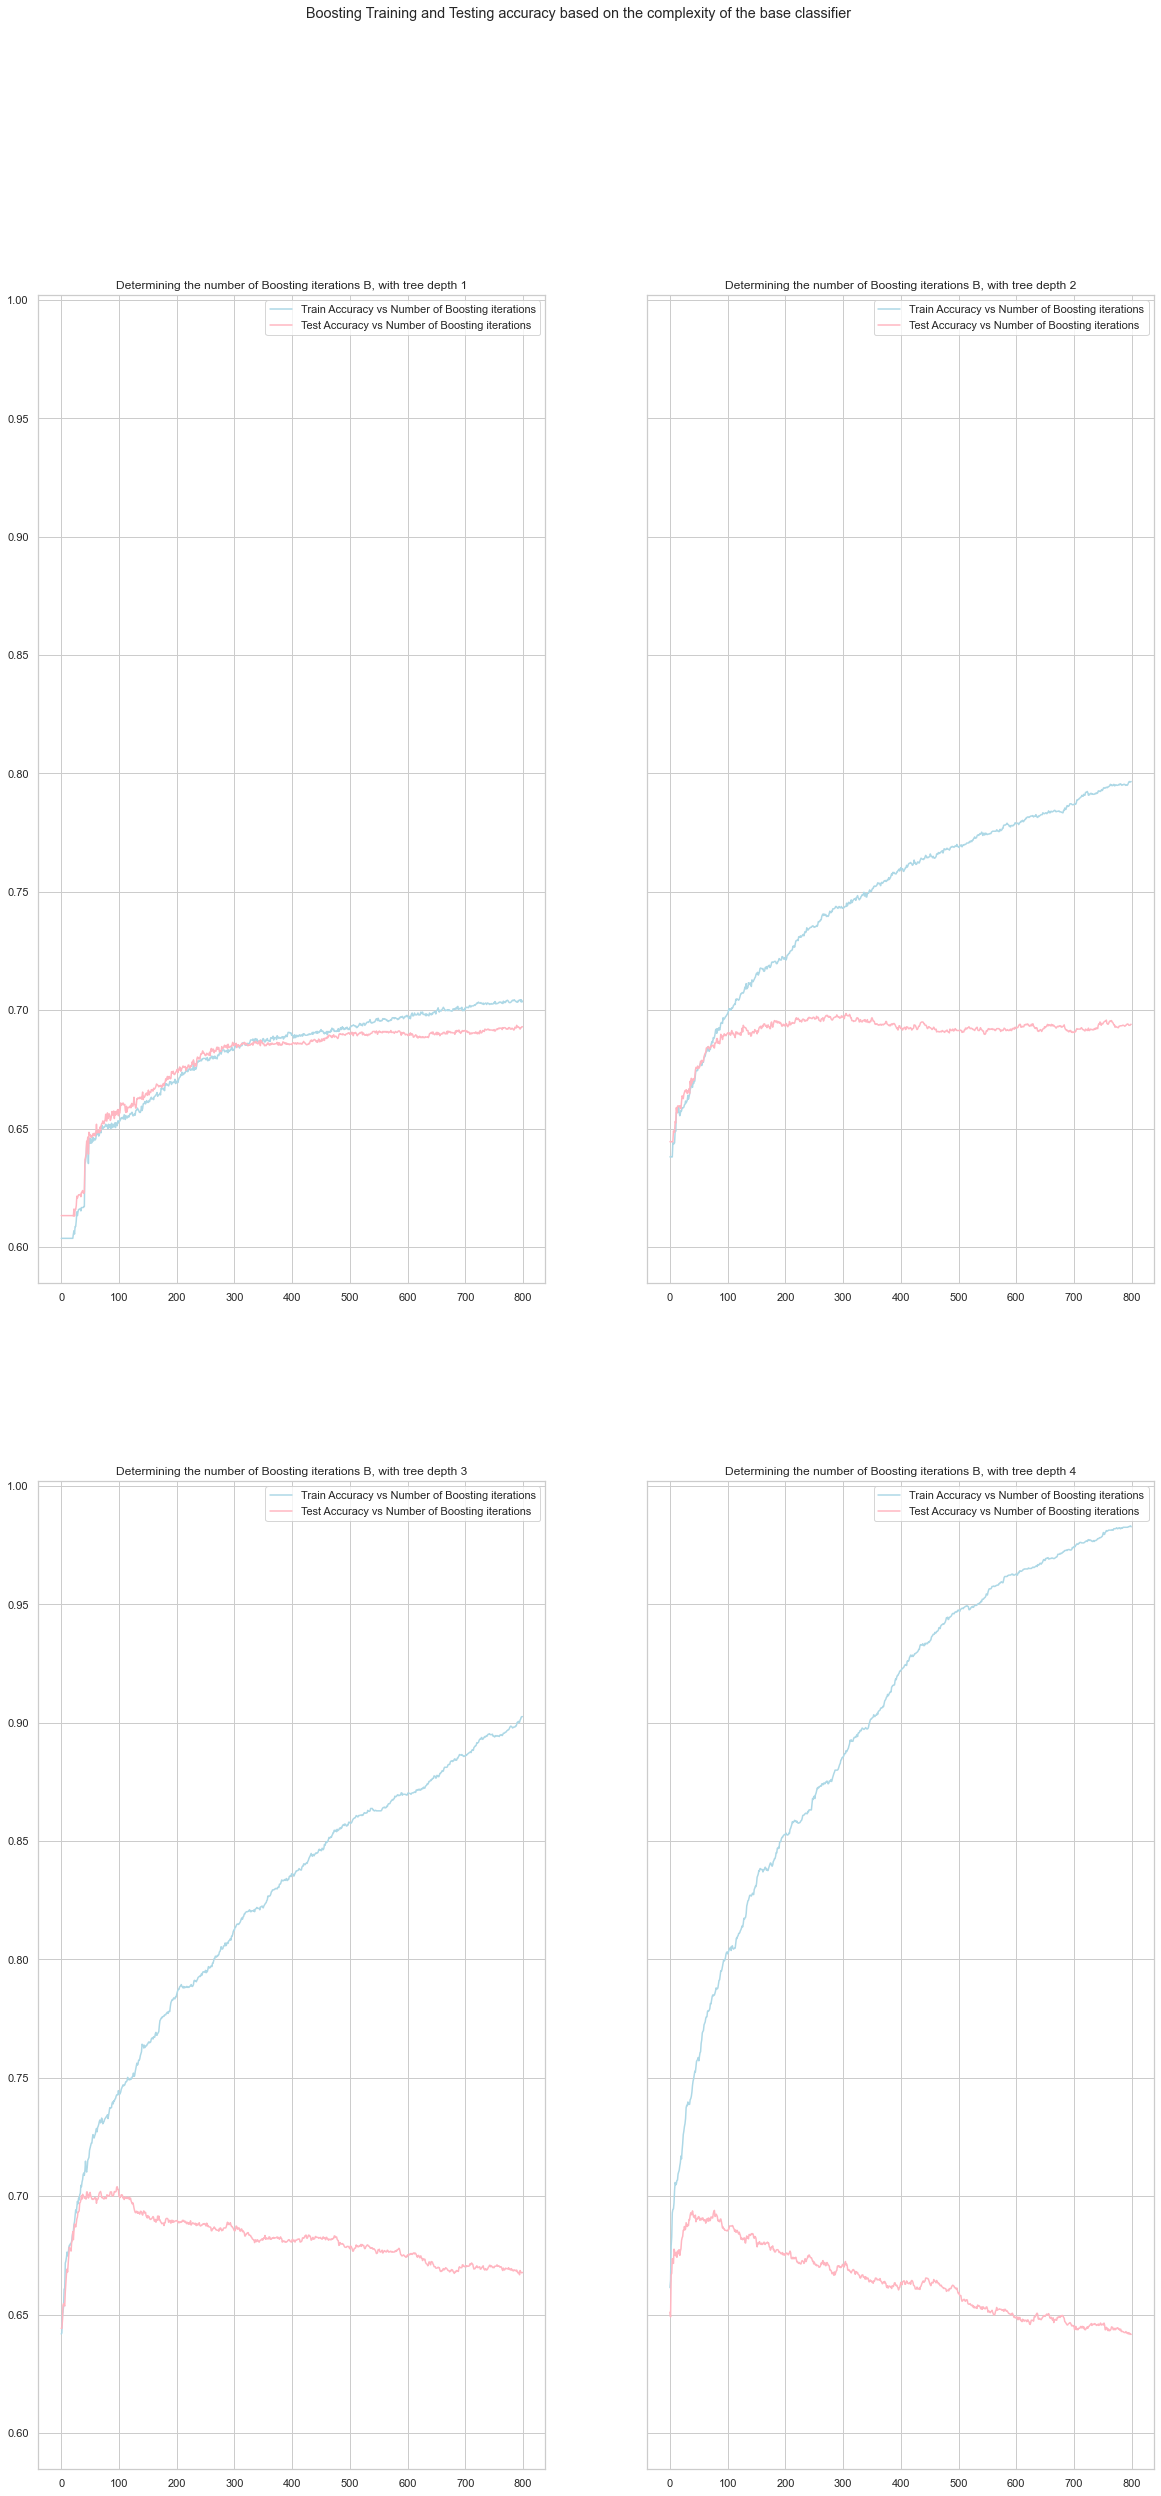

In [30]:
# your code here
depths = [1, 2, 3, 4]
fig, axes = plt.subplots(2, 2, figsize = (20, 40), sharey=True)
plt.suptitle('Boosting Training and Testing accuracy based on the complexity of the base classifier')
for i, ax in enumerate(axes.ravel()):
    boosting = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depths[i]), n_estimators=800, learning_rate=0.05).fit(X_train, y_train)
    staged_score_training = list(boosting.staged_score(X_train, y_train))
    staged_score_testing = list(boosting.staged_score(X_test, y_test))
    ax.set_title('Determining the number of Boosting iterations B, with tree depth '+str(depths[i]))
    ax.plot(staged_score_training, color='lightblue', label='Train Accuracy vs Number of Boosting iterations')
    ax.plot(staged_score_testing, color='lightpink', label='Test Accuracy vs Number of Boosting iterations')
    ax.legend()
plt.show(fig)

In [31]:
# your code here


We can see that using more complex models (parametrized by the *depth* of the based tree classifier) leads to increasing overfitting, while not automatically resulting in higher test accuray. This is why, based on our analysis, the best model is the one fitted when the base classifiers are decision trees with depth = 3. 

Other patterns that occured are that when the complexity of the base classifier is low, increasing the number of boosted trees does not lead to overfitting (because one classifier captures less noise in our data since it is less able to capture complex features in the data).


<div class='exercise-r'>  
 
**4.5** Based on the plot you just made, what combination of base learner depth and the number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?
 </div>

In [32]:
# your code here
results_df= pd.DataFrame({'classifier':['single tree with best depth chosen by CV', 'single depth-15 tree', 'Bagging 55 depth-15 trees', 'Random Forest of 55 depth-15 trees', 'AdaBoost with 97 depth-3 trees'], 
                         'training accuracy':[best_cv_tree_train_score, score_overfitting_train, bagging_accuracy_train, random_forest_train_score, best_boosting_depth_3_train], 
                         'testing accuracy':[best_cv_tree_test_score, score_overfitting_test, bagging_accuracy_test, random_forest_test_score, best_boosting_depth_3_test]}, index=None)
display(results_df)

,classifier,training accuracy,testing accuracy
0,single tree with best depth chosen by CV,0.6614,0.6510
1,single depth-15 tree,0.9816,0.6014
2,Bagging 55 depth-15 trees,0.9876,0.6848
3,Random Forest of 55 depth-15 trees,0.9976,0.6918
4,AdaBoost with 97 depth-3 trees,0.7428,0.7046


The performances of our Gradient Boosting Classifier with **98** trees, each of which have a depth **3** are better than our previous ensemble methods (but the differences are not very significant).  

### <div class='exercise'>Question 5 [15pts]: Understanding</div>
[▲ Return to contents](#Contents)
<div class='exercise'>
This question is intended to evaluate your overall knowledge and understanding of the current material. You may need to refer to lecture notes and other material outside this homework to answer these questions.
    

**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?


**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?

**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

**5.5** Which of these techniques can be extended to regression tasks? How?

</div>


## Answers

<div class='exercise-r'>  
 
**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?
 
 
 </div>

**How boosting and bagging are similar:**
- Both are ensemble models: we try to combine the strenghts of several rather simple models in order to achieve a more complex model that has better predictive capability
- In both models, we aggregate the predictions from every model


**How boosting and bagging are different:**
- Boosting is iterative: one model learns from the weaknesses of the previous one. In that way, in boosting the predictors are highly correlated. In boosting, the different models have different weigths and have a different importance in the aggregated resulting model. Boosting is prone to overfitting when increasing the number of base estimators and leveraging complex base models (trees with high depth).
- Bagging is parallelized: we try to render the models the most independent possible. In bagging, all the models have the same importance. Bagging is not prone to overfitting when increasing the number of base estimators and not prone to overfitting when using complex base estimators.

<div class='exercise-r'>  
 
**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?
 
 </div>

In [33]:
display(results_df)

,classifier,training accuracy,testing accuracy
0,single tree with best depth chosen by CV,0.6614,0.6510
1,single depth-15 tree,0.9816,0.6014
2,Bagging 55 depth-15 trees,0.9876,0.6848
3,Random Forest of 55 depth-15 trees,0.9976,0.6918
4,AdaBoost with 97 depth-3 trees,0.7428,0.7046


- The first single tree with depth chosen by cross-validation is a simple model that underfits complex patterns in the data
- Increasing the depth of the tree increases the score on the training data but leads to overfitting, resulting in a dramatic decrease in testing performances
- The bagging behaves as expected: is robust to overfitting and leads to an increased generalization performance 
- Random Forest generalizes better than bagging, due to the fact that the predictors are more decorrelated
- Gradient Boosting with tuned hyperparameters is the best model in terms of generalization error. This is what we expect from Gradient Boosting, which is a way to learn more complex patterns in the training data.

<div class='exercise-r'>  
 
**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?
 
 </div>

- In boosting, it leads to overfitting.
- In bagging, there is no impact: our model is robust to overfitting when increasing the number of base estimators.

It is worse to have too many trees when working with Gradient Boosting techniques.

<div class='exercise-r'>  
 
**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?
 
 </div>

Bagging is better suited to parallelization, because the estimation of all of the base estimators are not mutually dependent. We could estimate all of the base estimaros independently and at the same time.

<div class='exercise-r'>  
 
**5.5** Which of these techniques can be extended to regression tasks? How?
 
 </div>

Both Techniques (Boosting and Bagging) can be extended to regression tasks. We just need to change our base classifier to a single regression model (*Decision Tree Regressor*). Furthermore, for boosting it is significantly different from Adaboost. The loss regression we use in the GBM optimization algorithm should reflect a continuous pattern.

### End of Notebook